In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from scipy.stats import f_oneway
import random
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/15 17:10:53 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.29.56.17 instead (on interface eth0)
22/10/15 17:10:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/15 17:10:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/15 17:10:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Model 1: Transactions per merchant per month

In [2]:
# Load final dataset

finaldf = spark.read.parquet("../data/curated/finaldf.parquet/")
finaldf.limit(5)

order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%
2021-08-21,94729574738,16982,4821,23684,156.3091245999424,407ce815-54e1-4ae...,QLD,Female,Scelerisque Corpo...,computer programm...,4.51,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2022-04-24,45572698303,16982,4821,23684,115.38672513864692,72160f0d-06c5-432...,QLD,Female,Libero Proin Corp.,shoe shops,3.30,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2021-08-21,34695415993,16982,4821,23684,35.730567249104645,d4524ef6-1f75-4f2...,QLD,Female,Ultrices Vivamus ...,"cable, satellite,...",6.02,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2022-04-24,67400260923,16982,4821,23684,73.85811747094266,7acb9a9f-3ef6-4d4...,QLD,Female,Eleifend PC,computer programm...,5.97,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2021-08-19,86578477987,16982,4821,23684,41.45540307953735,e8be544a-a311-432...,QLD,Female,Leo In Consulting,"watch, clock, and...",6.43,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1


Extract the year and month from the order datetime into seperate columns, we will use these to both group the dataset and create a new feature int_month:

In [3]:
modeldf = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf = modeldf.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf.limit(5)

22/10/15 17:11:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%,year,month
2021-08-21,94729574738,16982,4821,23684,156.3091245999424,407ce815-54e1-4ae...,QLD,Female,Scelerisque Corpo...,computer programm...,4.51,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2021,8
2022-04-24,45572698303,16982,4821,23684,115.38672513864692,72160f0d-06c5-432...,QLD,Female,Libero Proin Corp.,shoe shops,3.30,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2022,4
2021-08-21,34695415993,16982,4821,23684,35.730567249104645,d4524ef6-1f75-4f2...,QLD,Female,Ultrices Vivamus ...,"cable, satellite,...",6.02,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2021,8
2022-04-24,67400260923,16982,4821,23684,73.85811747094266,7acb9a9f-3ef6-4d4...,QLD,Female,Eleifend PC,computer programm...,5.97,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2022,4
2021-08-19,86578477987,16982,4821,23684,41.45540307953735,e8be544a-a311-432...,QLD,Female,Leo In Consulting,"watch, clock, and...",6.43,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2021,8


In [4]:
# Get monthly transactions feature

modeldf = modeldf.groupBy("year","month","merchant_abn").agg(
    count("dollar_value").alias("monthly_transactions"),
)

In [5]:
# Turn year and month into field 'int_month'

MONTHS = 12
modeldf = modeldf.withColumn('int_month', MONTHS*(modeldf['year'] - 2021) + (modeldf['month'] - 1))
modeldf = modeldf.drop('year', 'month')
modeldf

merchant_abn,monthly_transactions,int_month
38736067045,418,17
90477374366,48,10
52160665475,533,15
80779820715,1467,4
74019238521,1275,10
24852446429,12696,9
45466221547,1064,14
10323485998,476,20
71094934182,1022,19
35014882568,836,11


If any of the valid merchant_abns from the final dataset do not have any transactions listed in the dataset, we will need to manually add a row stating this month had 0 monthly transactions.

In [6]:
# Get all valid merchant abns
merchant_abns = finaldf.select('merchant_abn').distinct().toPandas()['merchant_abn']

# Originally set all merchant abns to have 0 transactions every month
records = []
for m in merchant_abns:
    for int_month in range(1, 22):
        records.append([m, 0, int_month])        
defaultdf = spark.createDataFrame(records, 
                                  schema=['merchant_abn', 'monthly_transactions_0', 'int_month'])

# Now overwrite the values that are present in modeldf.
modeldf = defaultdf.join(modeldf, on=['merchant_abn', 'int_month'], how='left')
modeldf = modeldf.drop('monthly_transactions_0')
modeldf = modeldf.na.fill(value=0,subset=["monthly_transactions"])

In [7]:
modeldf.sort('merchant_abn', 'int_month')

merchant_abn,int_month,monthly_transactions
10023283211,1,3
10023283211,2,103
10023283211,3,117
10023283211,4,126
10023283211,5,129
10023283211,6,137
10023283211,7,122
10023283211,8,150
10023283211,9,141
10023283211,10,176


To determine the number of lags that are used, we build autocorrelation plots to determine the correlation between lags of the  monthly transactions feature. Note that these plots need to be created for an individual merchant, hence the code below chooses 5 random merchants (can uncomment the setting of the seed for this to becompletely randomised), and builds autocorrelation plots.

In [8]:
df = modeldf.toPandas()

In [9]:
# Perform one hot encoding on merchant abn so that it is treated as categorical in model

one_hot = pd.get_dummies(df['merchant_abn'])
df = df.join(one_hot)
df 

,merchant_abn,int_month,monthly_transactions,10023283211,10142254217,10165489824,10187291046,10192359162,10206519221,10255988167,...,99803748393,99807059634,99845294286,99861963809,99904689266,99938978285,99974311662,99976658299,99987905597,99990536339
0,35344855546,19,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38700038932,11,371,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,60654402457,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,78916025936,13,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61867784114,3,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84373,47047735645,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84374,18261886835,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84375,29623808496,21,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84376,22019281430,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


28690231799


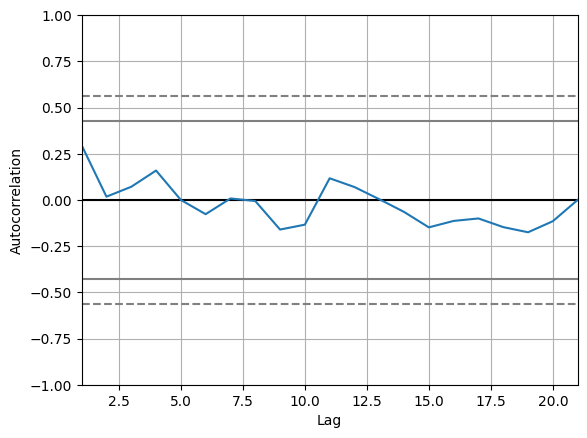

26994239326


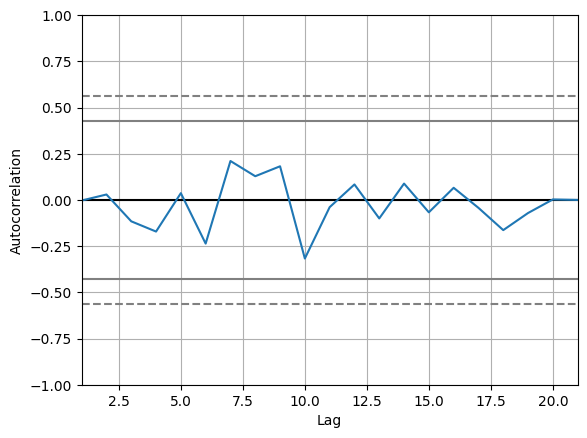

65022194603


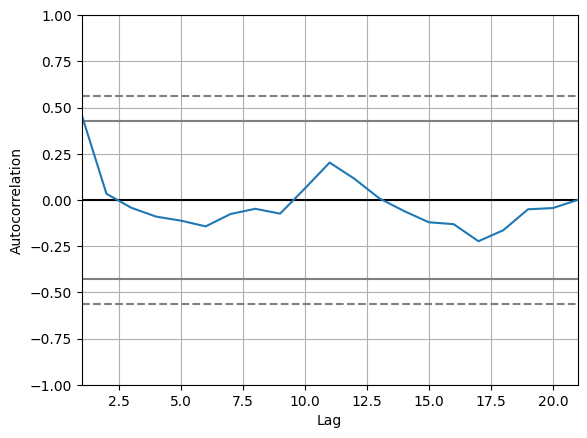

68252147715


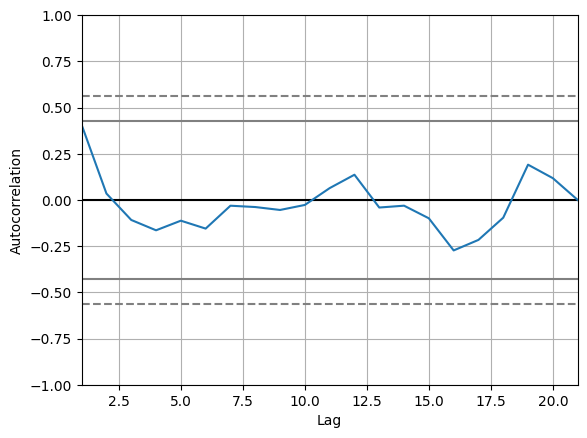

90477374366


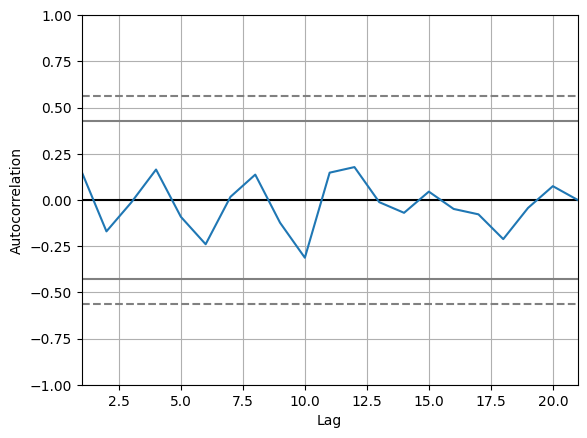

In [10]:
# We plot the autocorrelation for 5 random merchants

random.seed(4302022)

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    
    print(random_merchant)
    
    filtereddf = df[df[random_merchant] == 1][['int_month', 'monthly_transactions']]
    filtereddf = filtereddf.sort_values('int_month')
    filtereddf = filtereddf['monthly_transactions']
    
    x = pd.plotting.autocorrelation_plot(filtereddf)
 
    x.plot()
 
    plt.show()

First, note that the autocorrelation between all lags for the majority of merchants are inside the 95% confidence band indicated by the bold line. This indicates that no autocorrelations are significant from 0 at the 5% level of significance. 

However, it was noticed that for a large majority of merchants, a similar pattern emerged in that the two first 2 lags were consistently positively correlated. It was therefore decided we would build the model using two lags despite the insignificance.

This is likely an area that could be improved in future work on this topic, but since the models were intended to be basic in nature, it was not deemed to significant of an issue, particularly if the results obtained from the model were reasonable.

Below we prepare the dataframe for building the model, by both applying one hot encoding merchant abn, as this will be treated as a categorical variable by our model, and construction of the lags.

In [11]:
# Create new field merchant_abn_class, a number between 0-4017 representing a single merchant_abn 

indexer = StringIndexer(inputCol='merchant_abn', outputCol='merchant_abn_class')
indexer_fitted = indexer.fit(modeldf)
modeldf = indexer_fitted.transform(modeldf)
modeldf

merchant_abn,int_month,monthly_transactions,merchant_abn_class
35344855546,19,73,1181.0
38700038932,11,371,1327.0
60654402457,5,4,2279.0
78916025936,13,4,3108.0
61867784114,3,3,2323.0
37470904997,14,0,1270.0
46331355995,7,84,1668.0
35927874515,2,137,1214.0
14316652139,8,12,190.0
60616659469,6,21,2275.0


In [12]:
# Complete one hot encoding of merchant_abn

encoder = OneHotEncoder(inputCols=['merchant_abn_class'], outputCols=['merchant_abn_ohe'])
modeldf = encoder.fit(modeldf).transform(modeldf)
modeldf

merchant_abn,int_month,monthly_transactions,merchant_abn_class,merchant_abn_ohe
35344855546,19,73,1181.0,"(4017,[1181],[1.0])"
38700038932,11,371,1327.0,"(4017,[1327],[1.0])"
60654402457,5,4,2279.0,"(4017,[2279],[1.0])"
78916025936,13,4,3108.0,"(4017,[3108],[1.0])"
61867784114,3,3,2323.0,"(4017,[2323],[1.0])"
37470904997,14,0,1270.0,"(4017,[1270],[1.0])"
46331355995,7,84,1668.0,"(4017,[1668],[1.0])"
35927874515,2,137,1214.0,"(4017,[1214],[1.0])"
14316652139,8,12,190.0,"(4017,[190],[1.0])"
60616659469,6,21,2275.0,"(4017,[2275],[1.0])"


In [13]:
# Create the lagged variables

partition = Window.partitionBy("merchant_abn").orderBy("int_month")
modeldf = modeldf.withColumn('monthly_transactions-1', lag('monthly_transactions', 1).over(partition))
modeldf = modeldf.withColumn('monthly_transactions-2', lag('monthly_transactions', 2).over(partition))
modeldf.show(60)

+------------+---------+--------------------+------------------+----------------+----------------------+----------------------+
|merchant_abn|int_month|monthly_transactions|merchant_abn_class|merchant_abn_ohe|monthly_transactions-1|monthly_transactions-2|
+------------+---------+--------------------+------------------+----------------+----------------------+----------------------+
| 10023283211|        1|                   3|               0.0|(4017,[0],[1.0])|                  null|                  null|
| 10023283211|        2|                 103|               0.0|(4017,[0],[1.0])|                     3|                  null|
| 10023283211|        3|                 117|               0.0|(4017,[0],[1.0])|                   103|                     3|
| 10023283211|        4|                 126|               0.0|(4017,[0],[1.0])|                   117|                   103|
| 10023283211|        5|                 129|               0.0|(4017,[0],[1.0])|                   126|

In [14]:
# Remove the months without valid lagged variables

modeldf = modeldf.na.drop()
modeldf.count()

76342

Now we build our time series regression model, with our testing data being the final 3 months of the dataset.

In [15]:
SPLIT_MONTH = 18

# Prepare a features column for the model
vecAssembler = VectorAssembler(inputCols=['merchant_abn_ohe', 'int_month', 
                                          'monthly_transactions-1', 
                                          'monthly_transactions-2'], 
                               outputCol='features')

# Train test split
train = modeldf.filter(col('int_month') <= SPLIT_MONTH)
test = modeldf.filter(col('int_month') > SPLIT_MONTH)

# Apply transformation to both datasets
train = vecAssembler.transform(train)
test = vecAssembler.transform(test)
train

merchant_abn,int_month,monthly_transactions,merchant_abn_class,merchant_abn_ohe,monthly_transactions-1,monthly_transactions-2,features
10023283211,3,117,0.0,"(4017,[0],[1.0])",103,3,"(4020,[0,4017,401..."
10023283211,4,126,0.0,"(4017,[0],[1.0])",117,103,"(4020,[0,4017,401..."
10023283211,5,129,0.0,"(4017,[0],[1.0])",126,117,"(4020,[0,4017,401..."
10023283211,6,137,0.0,"(4017,[0],[1.0])",129,126,"(4020,[0,4017,401..."
10023283211,7,122,0.0,"(4017,[0],[1.0])",137,129,"(4020,[0,4017,401..."
10023283211,8,150,0.0,"(4017,[0],[1.0])",122,137,"(4020,[0,4017,401..."
10023283211,9,141,0.0,"(4017,[0],[1.0])",150,122,"(4020,[0,4017,401..."
10023283211,10,176,0.0,"(4017,[0],[1.0])",141,150,"(4020,[0,4017,401..."
10023283211,11,176,0.0,"(4017,[0],[1.0])",176,141,"(4020,[0,4017,401..."
10023283211,12,107,0.0,"(4017,[0],[1.0])",176,176,"(4020,[0,4017,401..."


In [16]:
# Train model

lr = LinearRegression(featuresCol='features', labelCol='monthly_transactions')
lrModel = lr.fit(train)

22/10/15 17:13:26 WARN Instrumentation: [06bf5ac7] regParam is zero, which might cause numerical instability and overfitting.
22/10/15 17:13:26 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/15 17:13:26 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/15 17:13:27 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [17]:
# Predict values for test data to evaluate model
 
predictions = lrModel.transform(test)
predictions

merchant_abn,int_month,monthly_transactions,merchant_abn_class,merchant_abn_ohe,monthly_transactions-1,monthly_transactions-2,features,prediction
10023283211,19,146,0.0,"(4017,[0],[1.0])",166,134,"(4020,[0,4017,401...",163.63956154699477
10023283211,20,173,0.0,"(4017,[0],[1.0])",146,166,"(4020,[0,4017,401...",151.06678475805126
10023283211,21,164,0.0,"(4017,[0],[1.0])",173,146,"(4020,[0,4017,401...",168.34671245059747
10142254217,19,149,1.0,"(4017,[1],[1.0])",149,125,"(4020,[1,4017,401...",148.30986648992936
10142254217,20,130,1.0,"(4017,[1],[1.0])",149,149,"(4020,[1,4017,401...",147.12922954354627
10142254217,21,185,1.0,"(4017,[1],[1.0])",130,149,"(4020,[1,4017,401...",138.0587451957229
10165489824,19,1,2.0,"(4017,[2],[1.0])",0,1,"(4020,[2,4017,401...",8.833525496002338
10165489824,20,1,2.0,"(4017,[2],[1.0])",1,0,"(4020,[2,4017,401...",10.505535479886703
10165489824,21,0,2.0,"(4017,[2],[1.0])",1,1,"(4020,[2,4017,401...",11.45944806916243
10187291046,19,15,3.0,"(4017,[3],[1.0])",13,13,"(4020,[3,4017,401...",22.77479081396434


22/10/15 17:14:10 WARN DAGScheduler: Broadcasting large task binary with size 1363.1 KiB
28690231799


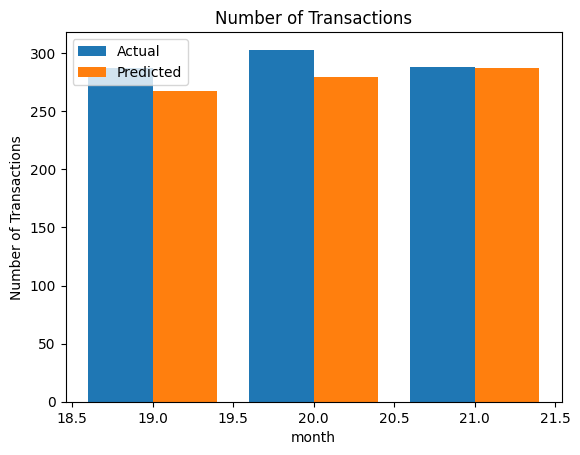

26994239326


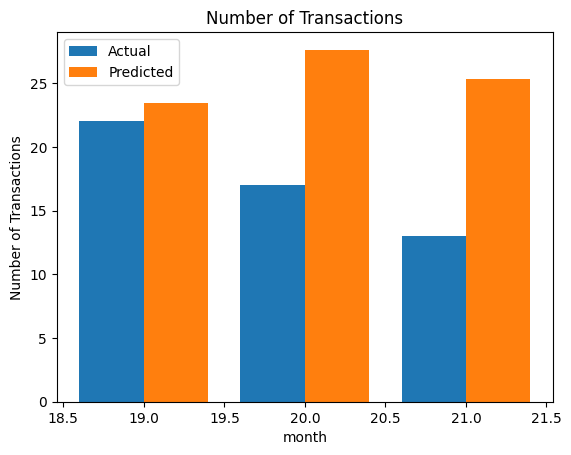

65022194603


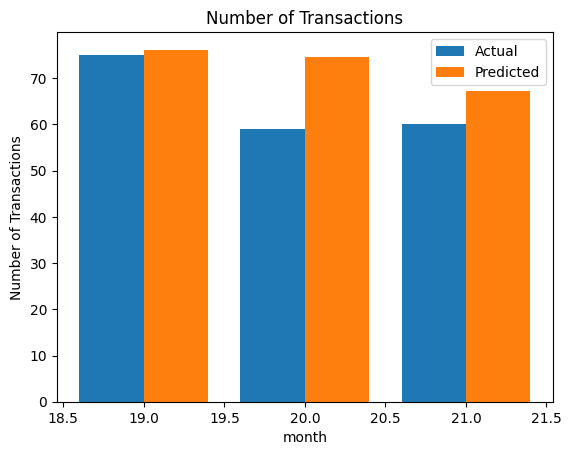

68252147715


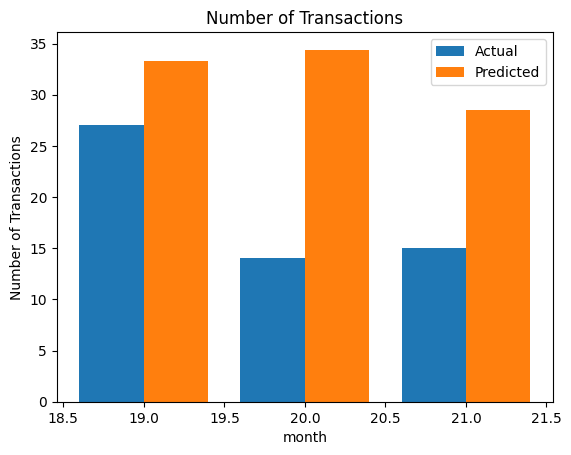

90477374366


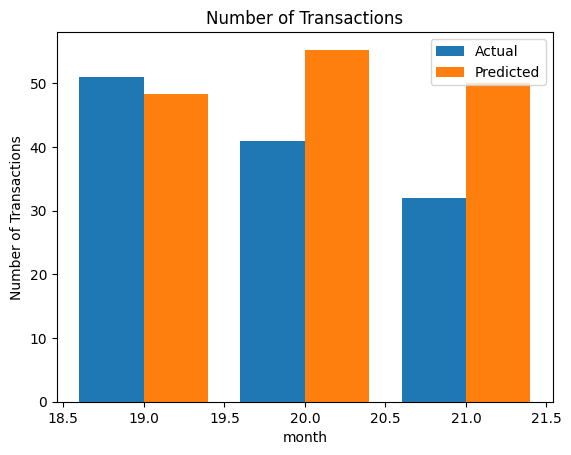

In [18]:
# Compare predictions and actual values for 5 random merchants
random.seed(4302022)

dfp = predictions.toPandas()
predictions.write.mode("overwrite").parquet("../data/curated/trans_num_predictions.parquet")
X = [19, 20, 21]

for i in range(5):
    random_merchant = random.sample(merchant_abns.tolist(), 1)[0]
    print(random_merchant)
    X_axis = np.arange(19, 22)
    plt.bar(X_axis - 0.2, dfp[dfp['merchant_abn']==random_merchant]["monthly_transactions"], 0.4, label = 'Actual')
    plt.bar(X_axis + 0.2, dfp[dfp['merchant_abn']==random_merchant]["prediction"], 0.4, label = 'Predicted')
    plt.legend()
    plt.xlabel('month')
    plt.ylabel('Number of Transactions')
    plt.title('Number of Transactions')
    plt.show()

In [19]:
# Mean Absolute Error

print(mae(dfp["monthly_transactions"],  dfp["prediction"]))

17.268581125035247


# Simulation

Build up predictions until we reach 2023. This needs to be done somewhat manually since we require previous predictions to then be used as lagged variables for the next months predictions. 

**Expect total run time of the following code to take several minutes.**

In [20]:
pdf = predictions.select('merchant_abn', 'int_month', 'prediction', 'merchant_abn_ohe').toPandas()
pdf

,merchant_abn,int_month,prediction,merchant_abn_ohe
0,10023283211,19,163.639562,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10023283211,20,151.066785,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,10023283211,21,168.346712,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,10142254217,19,148.309866,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,10142254217,20,147.129230,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
12049,99987905597,20,16.596160,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12050,99987905597,21,23.153337,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12051,99990536339,19,10.157479,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12052,99990536339,20,11.643876,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [21]:
# We build predictions for every merchant, one month at a time 
records = []
for int_month in range(22, 36):
    merchant_data = []
    
    # Build up required information for this month's prediction for all merchants
    for m in merchant_abns:
        merchant_abn_ohe = pdf.loc[(pdf['merchant_abn']==m) & (pdf['int_month']==21), 'merchant_abn_ohe'].values[0]
        merchant_data.append([m, merchant_abn_ohe, int_month, 
                              float(pdf.loc[(pdf['merchant_abn']==m) & 
                                            (pdf['int_month']==(int_month-2)), 'prediction'].values[0]),
                              float(pdf.loc[(pdf['merchant_abn']==m) & 
                                            (pdf['int_month']==(int_month-1)), 'prediction'].values[0])])  
    predictiondf = spark.createDataFrame(merchant_data, 
                                         schema=['merchant_abn', 'merchant_abn_ohe', 'int_month', 'monthly_transactions-1', 
                                                 'monthly_transactions-2'])
    
    # Now perform the predictions
    predictiondf = vecAssembler.transform(predictiondf)
    predictiondf = lrModel.transform(predictiondf)
    pdf = pd.concat([pdf, predictiondf.select('merchant_abn', 'int_month', 'prediction', 'merchant_abn_ohe').toPandas()])
    
    # Once we have reached 2023, start storing the predictions
    if int_month >= 24:
        for m in merchant_abns:
            records.append([2021 + (int_month//12), (int_month%12) + 1, m, 
                            float(pdf.loc[(pdf['merchant_abn']==m) & 
                                          (pdf['int_month']==(int_month)), 'prediction'].values[0])])

In [22]:
future_trans_sdf = spark.createDataFrame(records, schema=['year', 'month', 'merchant_abn', 'total_transactions'])

future_trans_sdf.write.mode("overwrite").parquet("../data/curated/futuretrans.parquet/")

22/10/15 17:16:09 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 96.51% for 14 writers
